## Import libs and read inputs

In [1]:
import os
# import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils


Welcome to ROOTaaS 6.06/05


In [2]:
import ROOT as RT

In [7]:
from glob import glob 

In [8]:
fnames = glob('/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/outfiles/20170711_highMassCut/GluGluToHHTo2B2G_node_*_13TeV-madgraph_preselection.root')

In [9]:
nodes = { name.split("node")[1].split("_")[1] : RT.TFile.Open(name) for name in fnames } 

In [10]:
keys = sorted(nodes.keys())

In [11]:
import root_pandas as rpd
import pandas as pd

dfs = []

for key in keys:
    inode = int(key) if key != 'SM' else 0
    idf = rpd.read_root(nodes[key].GetName())
    idf['proc'] = np.ones((idf.shape[0],1),dtype=np.int32)*inode
    dfs.append(idf)

df = pd.concat(dfs)

In [12]:
import xgboost as xgb

/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Weighting

In [231]:
mxbins = np.arange(200,804,4)
mxbins[-1] = 1e+5
df['MXBin'] = pd.cut(df['MX'],mxbins)




tab completion not implemented for this context


In [297]:
labels,probs = np.unique(df['proc'],return_counts=True)

probs = probs.astype(np.float32)
probs /= np.sum(probs)
cw = 1./probs

class_weight = { x[0]:x[1] for x in zip(labels,cw)  }

# df['class_weight'] = df['proc'].apply(weight.get)
print(probs,cw)

(array([ 0.07747731,  0.07630971,  0.08117126,  0.07672938,  0.06946614,
        0.078674  ,  0.07930975,  0.06607553,  0.07042599,  0.07267394,
        0.07875711,  0.08509374,  0.08783615], dtype=float32), array([ 12.90700436,  13.10449219,  12.31963158,  13.03281784,
        14.39550209,  12.71067905,  12.6087904 ,  15.13419628,
        14.19930363,  13.76009083,  12.69726658,  11.75174522,  11.38483334], dtype=float32))


In [298]:
mx_weight = df.groupby(['proc','MXBin'])['proc'].count() / df.groupby('proc')['proc'].count()

In [307]:
df['weight'] = df[['proc','MXBin']].apply(lambda x: (class_weight.get(x[0])/mx_weight.loc[x[0],x[1]]), raw=True, axis=1   )
# df['weight'] = df[['proc','MXBin']].apply(lambda x: class_weight.get(x[0]), raw=True, axis=1   )


variable "df" not defined.

variable "df.shap" not defined.


In [309]:
df['weight'] *= float(df.shape[0]) / df['weight'].sum() 

In [310]:
df.groupby('proc')['weight'].sum()

proc
0     18512.615923
2     18512.615600
3     18512.615894
4     18512.616771
5     18512.615979
6     18512.615461
7     18512.614315
8     18512.614850
9     18512.615458
10    18512.614797
11    18512.614962
12    18512.614940
13    18512.615051
Name: weight, dtype: float64

## Node adversary

In [447]:
clf = xgb.XGBClassifier(max_depth=5,learning_rate=0.2,n_estimators=700,reg_lambda=1,min_child_weight=1e-5, nthread=12)

In [448]:
X = df[ ['MVAOutput'] ]
y = df[ ['proc'] ]
w = df[ ['weight'] ] 

In [449]:
from sklearn.model_selection import train_test_split

In [450]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w)

In [451]:
clf.fit(X_train,y_train,w_train.values.ravel())

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=5,
       min_child_weight=1e-05, missing=None, n_estimators=700, nthread=12,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [452]:
from sklearn.metrics import confusion_matrix

In [453]:
y_pred = clf.predict(X_test)

In [454]:
mtx = confusion_matrix(y_test,y_pred,sample_weight=w_test.values.ravel()).astype(np.float32)

norm = mtx.sum(axis=1)
mtx /= norm[:,np.newaxis]
norm / norm.sum()
mtx.sum(axis=1)

array([ 1.        ,  1.        ,  1.        ,  0.99999994,  0.99999988,
        1.00000012,  0.99999994,  1.00000012,  0.99999988,  0.99999994,
        1.        ,  1.00000012,  1.        ], dtype=float32)

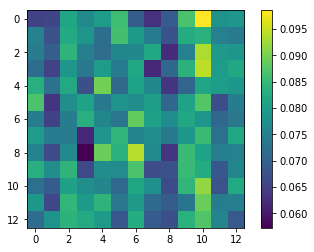

In [455]:
plt.imshow(mtx)
plt.colorbar()

In [456]:
# labels,probs = np.unique(y_test,return_counts=True)

probs = df.groupby('proc')['weight'].sum()

# print(weights)

probs = probs.astype(np.float32)
probs /= np.sum(probs)
probs

proc
0     0.076923
2     0.076923
3     0.076923
4     0.076923
5     0.076923
6     0.076923
7     0.076923
8     0.076923
9     0.076923
10    0.076923
11    0.076923
12    0.076923
13    0.076923
Name: weight, dtype: float32

In [457]:
# y_random = np.random.choice(labels,y_pred.shape[0],p=probs)
rnd_acc = (probs * probs).sum()

In [458]:
# rnd_acc = (y_random.reshape(-1,1) == y_test).mean()
# rnd_acc

In [459]:
((y_pred.reshape(-1,1) == y_test).values.ravel()*w_test.values.ravel()).sum()/w_test.sum() / rnd_acc

weight    1.009654
dtype: float64

## MX adversary

In [436]:
X = df[ ['MVAOutput'] ]
y = df[ ['MX'] ]
w = df[ ['weight'] ]



In [437]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w)

In [438]:
reg = xgb.XGBRegressor(max_depth=5,learning_rate=0.15,n_estimators=700,reg_lambda=1,min_child_weight=1e-5, nthread= 12)

In [439]:
reg.fit(X_train,y_train.values.ravel())#,w_train.values.ravel())

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.15, max_delta_step=0, max_depth=5,
       min_child_weight=1e-05, missing=None, n_estimators=700, nthread=12,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [440]:
y_pred = reg.predict(X_test)

In [441]:
delta = (y_pred-y_test.values.ravel())/y_test.values.ravel()

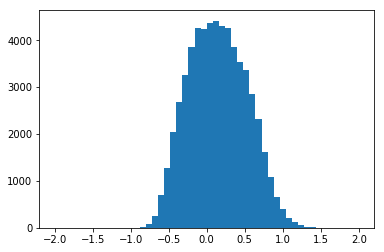

In [442]:
plt.hist(delta,bins=50,range=[-2,2]);

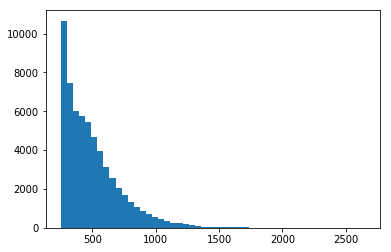

In [443]:
plt.hist(y_test.values.ravel(),bins=50);

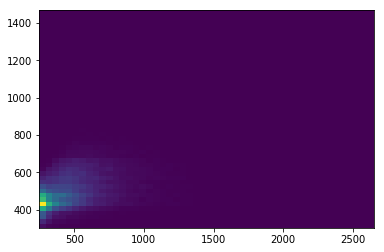

In [444]:
plt.hist2d(y_test.values.ravel(),y_pred,bins=50);

In [445]:
delta.mean(),delta.std()

(0.14673549233104019, 0.38073906743076047)

In [446]:
np.corrcoef(y_test.values.ravel(),y_pred)

array([[ 1.        ,  0.36491809],
       [ 0.36491809,  1.        ]])

In [188]:
hists = {}

for key,fil in nodes.iteritems():
    tree = fil.Get('reducedTree')
    tree.Draw("MX>>h_mX_%s(200,200,800)" % key)
    tree.Draw("MVAOutput>>h_MVA_%s(200,0,1)" % key)
    tree.Draw("MVAOutput:MX>>h_MVA_mX_%s(100,200,800,100,0,1)" % key)
    hist_MVA = RT.gDirectory.Get("h_MVA_%s" % key)
    hist_MX = RT.gDirectory.Get("h_mX_%s" % key)
    hist_MVA_MX = RT.gDirectory.Get("h_MVA_mX_%s" % key)
    hists[ key ] = ( hist_MVA, hist_MX, hist_MVA_MX )

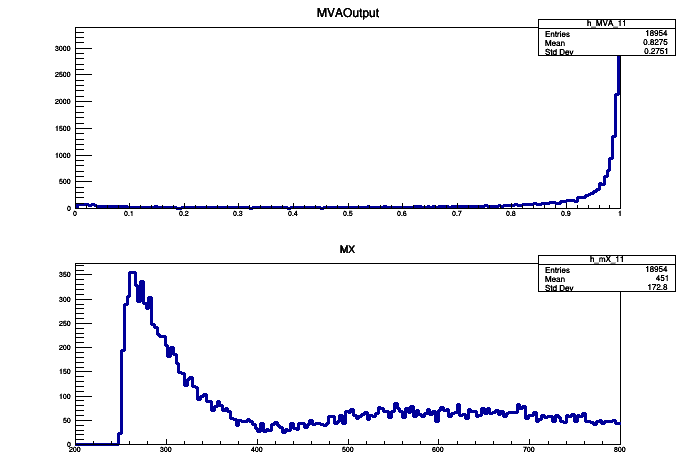

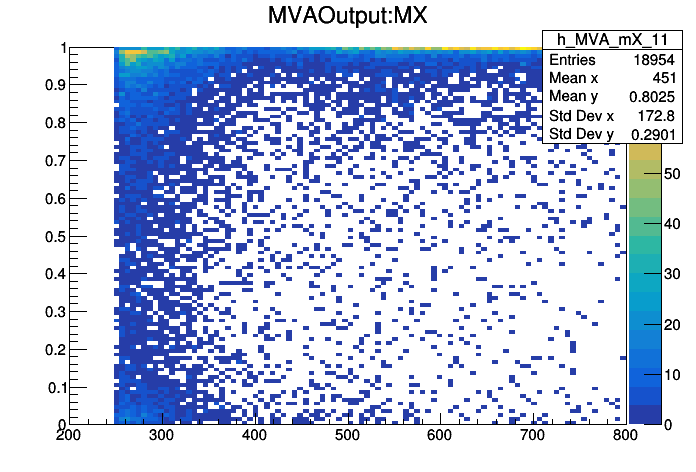

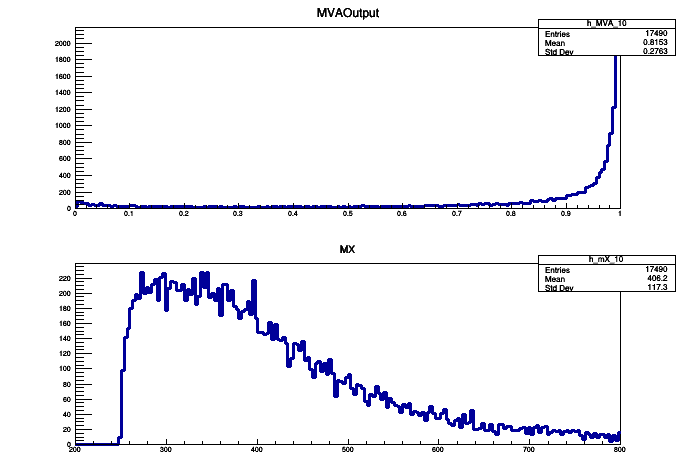

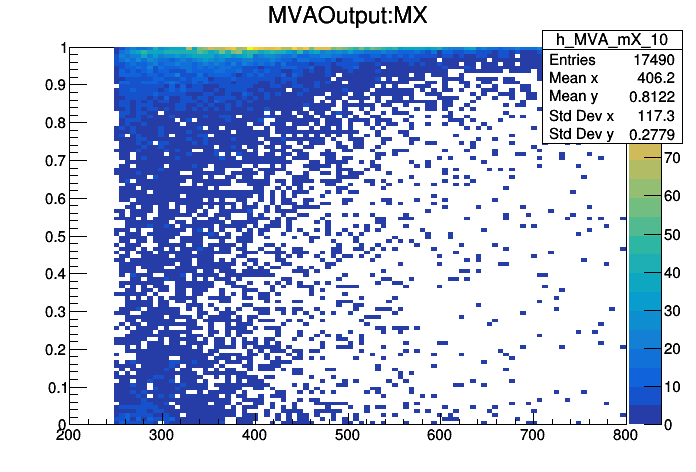

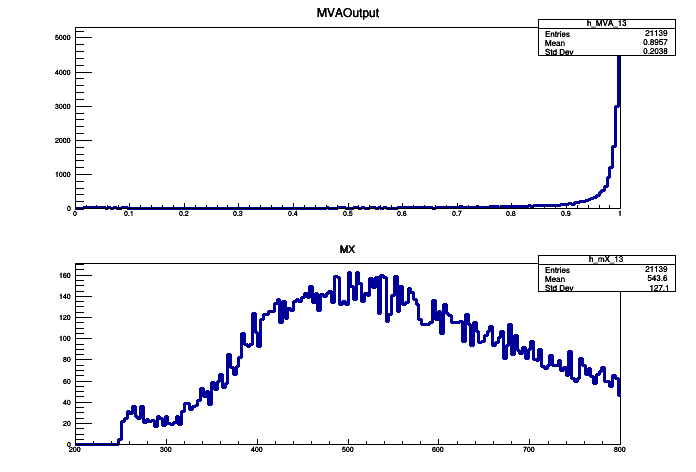

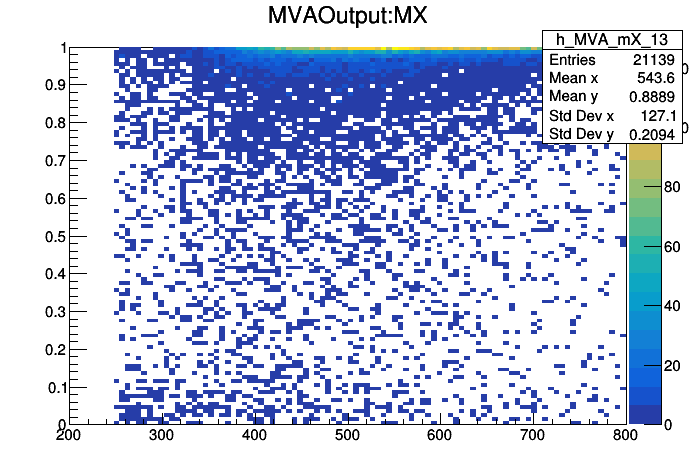

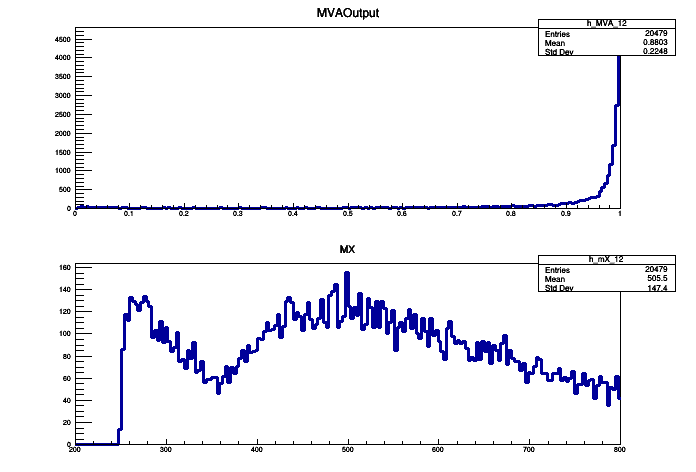

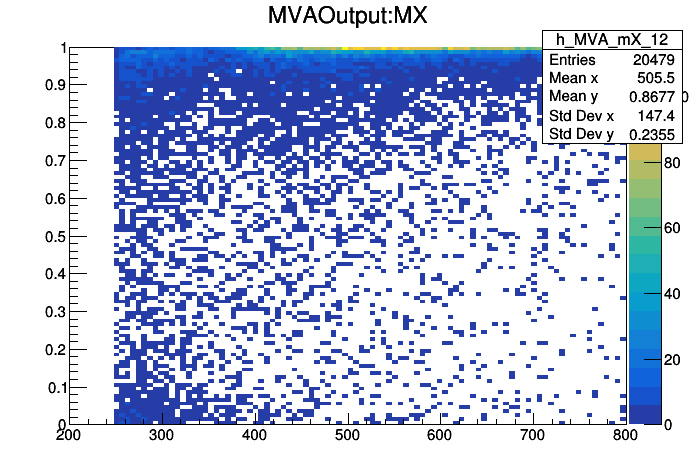

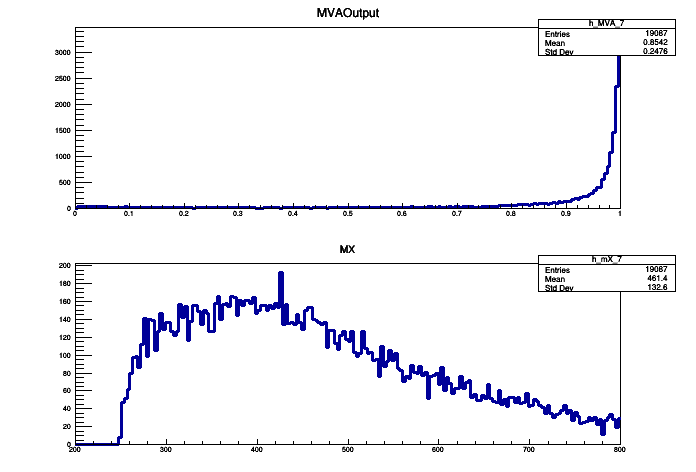

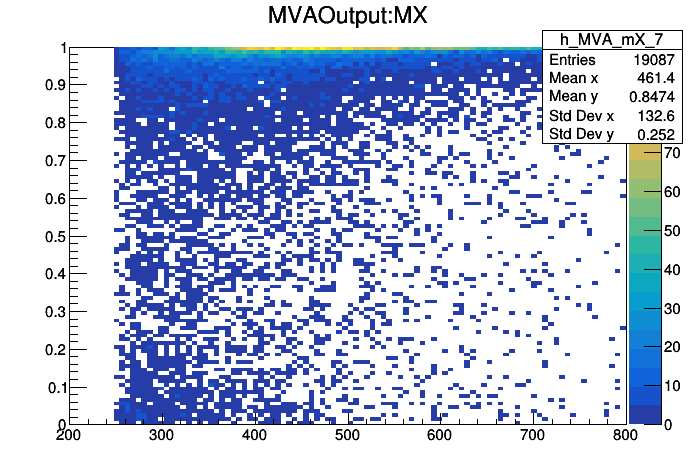

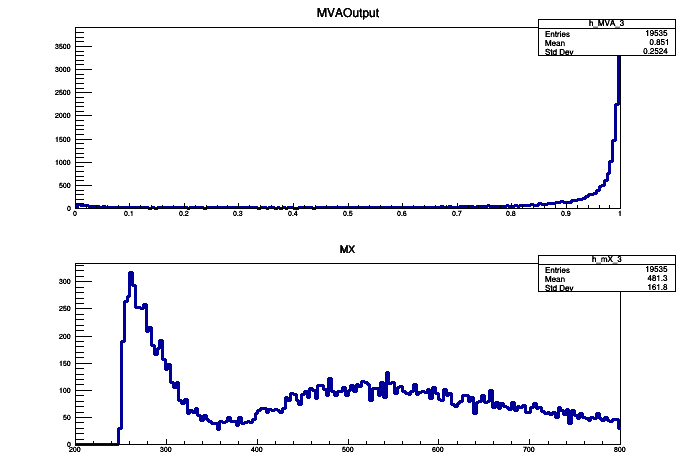

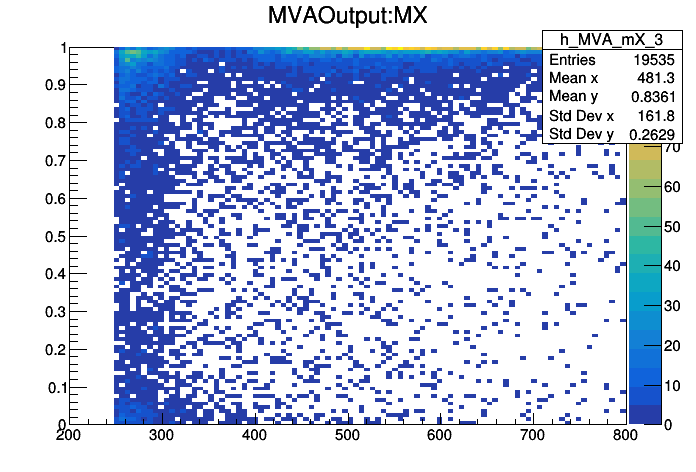

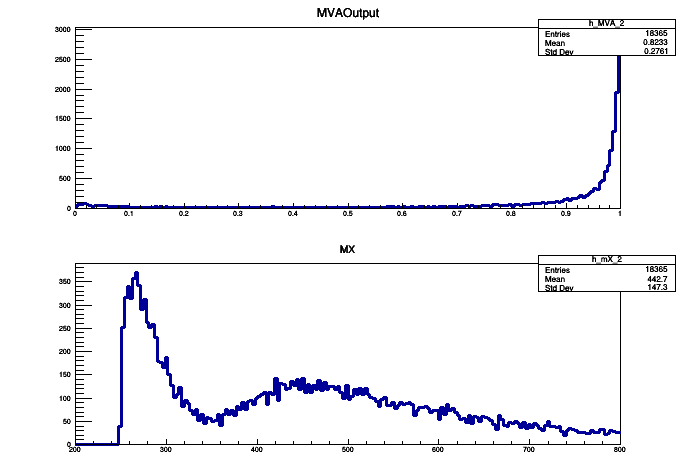

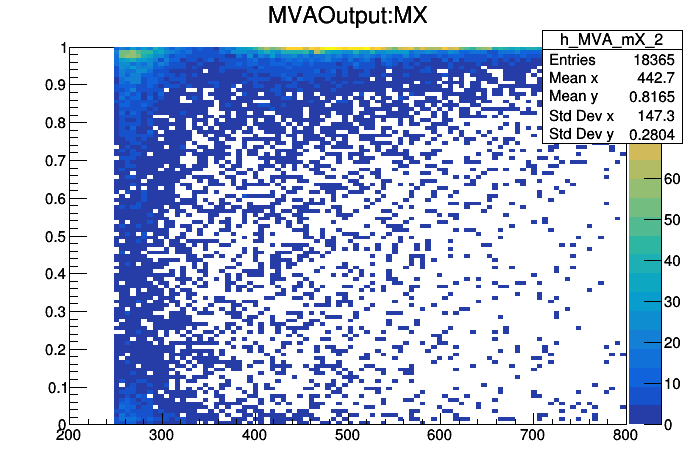

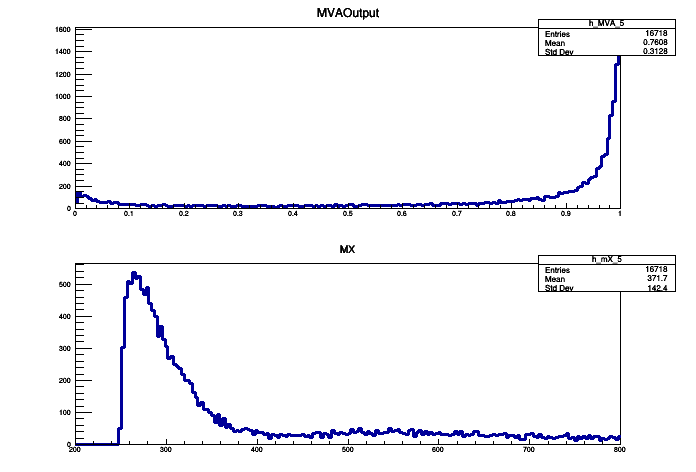

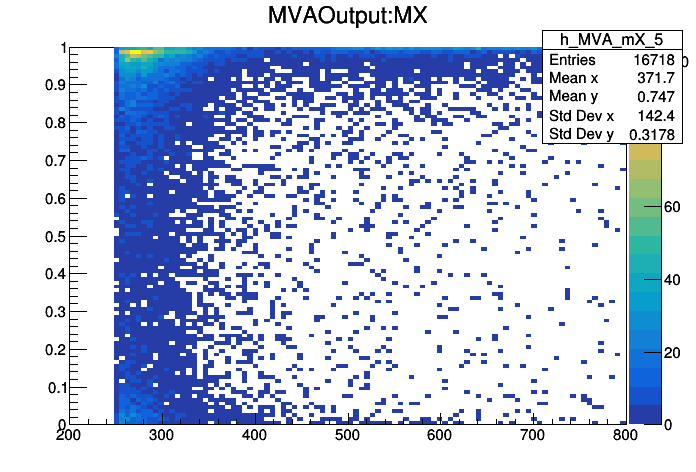

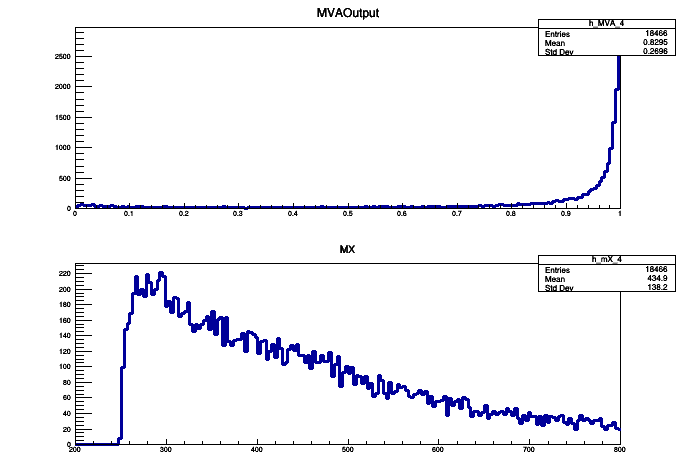

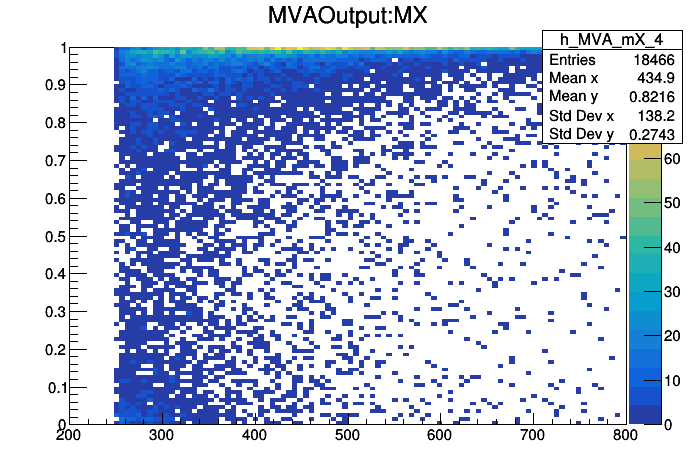

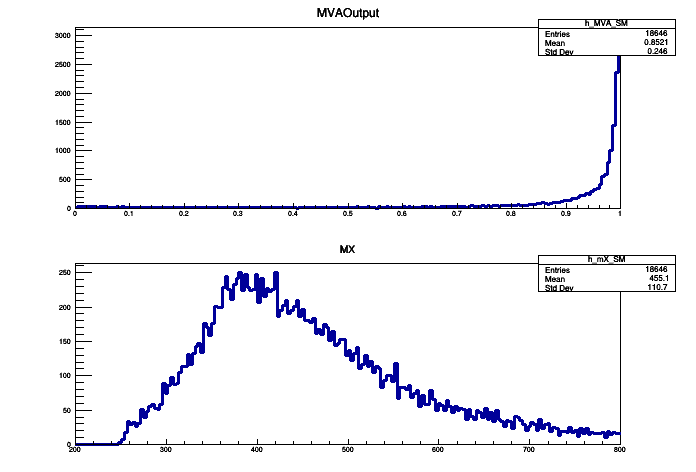

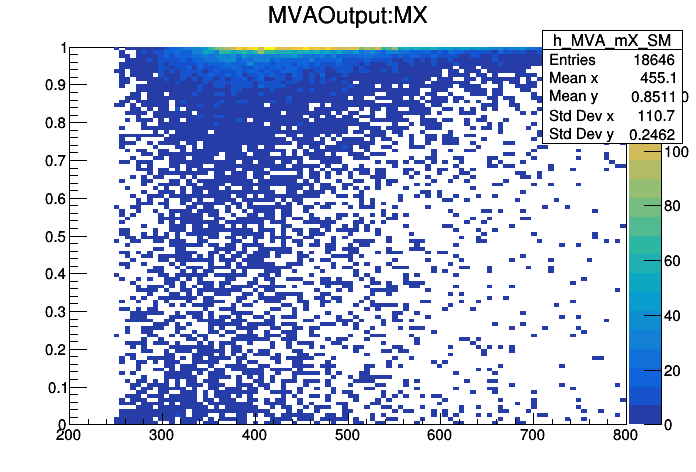

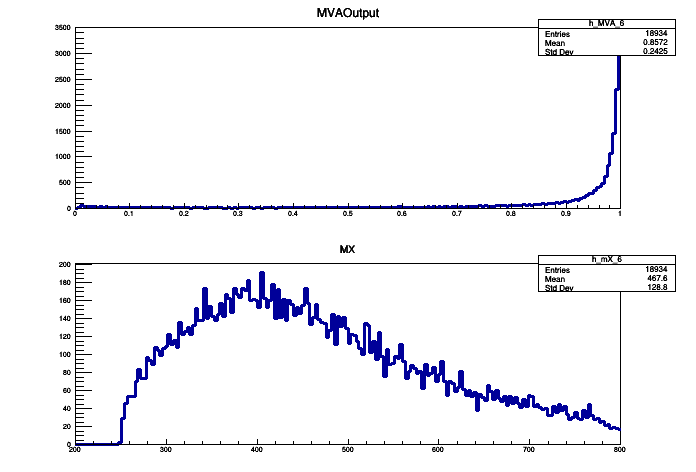

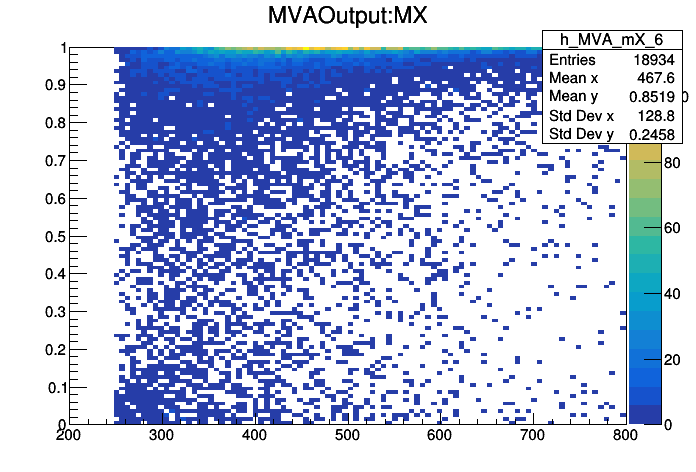

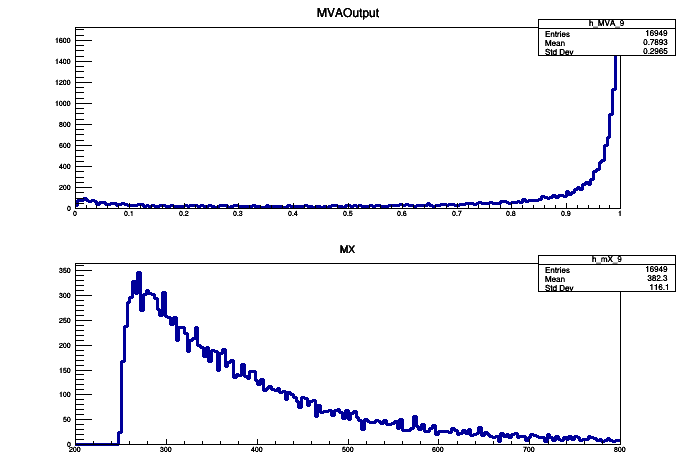

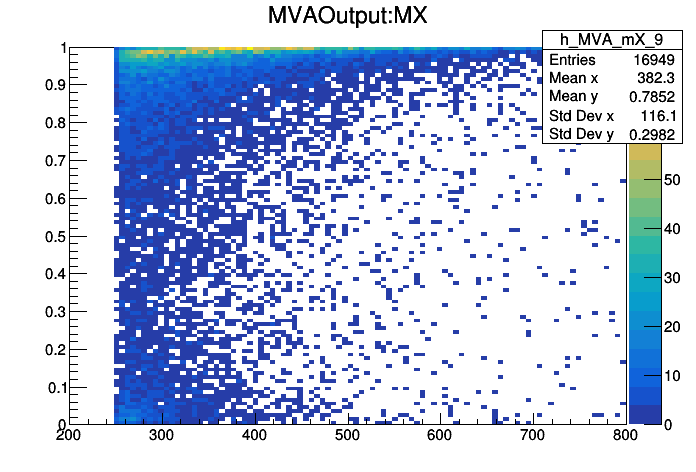

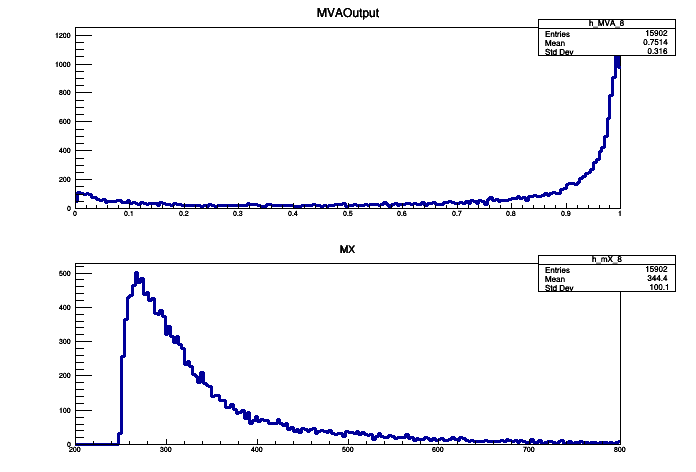

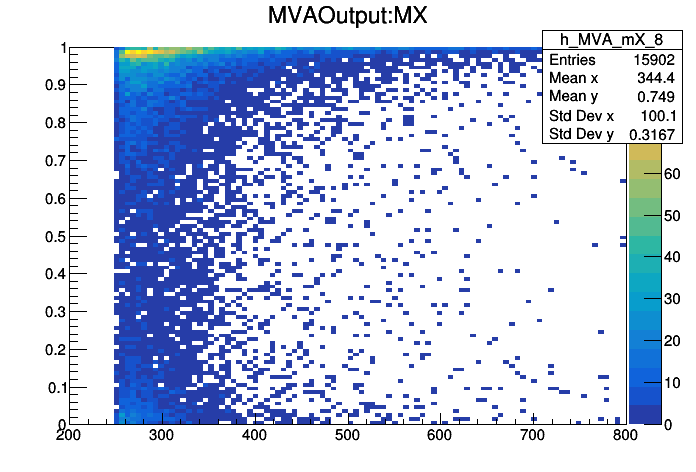

In [189]:
canv1 = RT.TCanvas()
canv1.Divide(1,2)
canv2 = RT.TCanvas()

for key, hist in hists.iteritems():
    canv1.cd(1)
    hist[0].Draw()
    canv1.cd(2)
    hist[1].Draw()
    canv1.Draw()
    canv2.cd()
    hist[2].Draw("colz")
    canv2.Draw()

In [ ]:
import training_utils as utils

In [119]:
y_random1 = np.random.choice(labels,y_pred.shape[0]).astype(np.float32)
y_random2 = np.random.choice(labels,y_pred.shape[0]).astype(np.float32)

(y_random1 == y_random2).astype(np.float32).mean()

0.077635206

P = $\sum_1^N P(n_i) * \sum_1^N P(n_j == n_i)  = \sum_1^N P(n_i)^2 = \sum_1^N 1 / N^2 $